In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Get project root (go up from scripts/models to project root)
PROJECT_ROOT = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
df = pd.read_csv(PROJECT_ROOT / "data" / "gold" / "gold_dataset.csv")
leakage_features = [
    "subject_id",
    "hadm_id",
    
]
X = df.drop(columns=["y"] + leakage_features)
y = df["y"].astype(int)

In [2]:
df.head()

,subject_id,hadm_id,gender,anchor_age,catheter_present,bmi,diabetes,cancer,chronic_kidney_disease,neurogenic_bladder,...,mobility_status_out_of_bed_with_assistance,mobility_status_unknown,mobility_status_wheelchair,catheter_type_condom,catheter_type_foley,catheter_type_nephrostomy,catheter_type_straight,catheter_type_suprapubic,catheter_type_unknown,catheter_type_ureteral
0,10000032,22595853,0,-0.643593,1,-1.537167,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,10000032,29079034,0,-0.643593,1,-1.506081,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,10000032,25742920,0,-0.643593,1,-1.506081,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000560,28979390,0,-0.585292,1,0.063762,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,10000690,25860671,0,1.338645,1,-0.760017,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split

# =====================================================
# Leave-One-Subject-Out (LOSO) Split
# Split by subject_id to ensure all admissions for a patient
# stay together in the same dataset (train/val/test)
# =====================================================

# Get unique subject_ids
unique_subjects = df["subject_id"].unique()
print(f"Total unique subjects: {len(unique_subjects)}")

# First split: 70% train, 30% temp (which will be split into 15% val + 15% test)
# We need to stratify by the target distribution at subject level
# For each subject, get the majority class (or any class if mixed)
subject_labels = df.groupby("subject_id")["y"].agg(lambda x: 1 if x.sum() > 0 else 0).values

# Split subjects: 70% train, 30% temp
subjects_train, subjects_temp, labels_train, labels_temp = train_test_split(
    unique_subjects,
    subject_labels,
    test_size=0.3,
    stratify=subject_labels,
    random_state=42
)

# Split temp (30%) into validation (15%) and test (15%)
# Calculate the proportion: 15% of total = 50% of temp (since temp is 30% of total)
subjects_val, subjects_test, labels_val, labels_test = train_test_split(
    subjects_temp,
    labels_temp,
    test_size=0.5,  # 50% of temp = 15% of total
    stratify=labels_temp,
    random_state=42
)

print(f"\nSplit summary:")
print(f"Training subjects: {len(subjects_train)} ({len(subjects_train)/len(unique_subjects)*100:.1f}%)")
print(f"Validation subjects: {len(subjects_val)} ({len(subjects_val)/len(unique_subjects)*100:.1f}%)")
print(f"Test subjects: {len(subjects_test)} ({len(subjects_test)/len(unique_subjects)*100:.1f}%)")

# Get all rows for each subject group
train_mask = df["subject_id"].isin(subjects_train)
val_mask = df["subject_id"].isin(subjects_val)
test_mask = df["subject_id"].isin(subjects_test)

X_train = X[train_mask].copy()
X_val = X[val_mask].copy()
X_test = X[test_mask].copy()

y_train = y[train_mask].copy()
y_val = y[val_mask].copy()
y_test = y[test_mask].copy()

print(f"\nDataset sizes:")
print(f"Training: {len(X_train)} admissions")
print(f"Validation: {len(X_val)} admissions")
print(f"Test: {len(X_test)} admissions")

print(f"\nTarget distribution in training:")
print(y_train.value_counts())
print(f"\nTarget distribution in validation:")
print(y_val.value_counts())
print(f"\nTarget distribution in test:")
print(y_test.value_counts())

Total unique subjects: 96242

Split summary:
Training subjects: 67369 (70.0%)
Validation subjects: 14436 (15.0%)
Test subjects: 14437 (15.0%)

Dataset sizes:
Training: 110541 admissions
Validation: 23668 admissions
Test: 23811 admissions

Target distribution in training:
y
0    109262
1      1279
Name: count, dtype: int64

Target distribution in validation:
y
0    23367
1      301
Name: count, dtype: int64

Target distribution in test:
y
0    23556
1      255
Name: count, dtype: int64


In [4]:
# =====================================================
# Save test samples to CSV files for testing
# Save 5 samples with y=0 and 5 samples with y=1
# Samples are randomly shuffled each time
# =====================================================
from pathlib import Path
import pandas as pd

# Create test dataframe with all columns (including subject_id, hadm_id, but excluding y in output)
test_df = df[test_mask].copy()

# Create testing_csvs directory (relative to project root)
# PROJECT_ROOT is already defined in the first cell
testing_dir = PROJECT_ROOT / "testing_csvs"
testing_dir.mkdir(parents=True, exist_ok=True)

# Shuffle and select 5 random samples with y=0 (no CAUTI)
test_y0 = test_df[test_df['y'] == 0].sample(n=min(5, len(test_df[test_df['y'] == 0])), random_state=None).reset_index(drop=True)
print(f"Selected {len(test_y0)} random samples with y=0")

# Shuffle and select 5 random samples with y=1 (CAUTI)
test_y1 = test_df[test_df['y'] == 1].sample(n=min(5, len(test_df[test_df['y'] == 1])), random_state=None).reset_index(drop=True)
print(f"Selected {len(test_y1)} random samples with y=1")

# Save each row as a separate CSV file (without y column)
saved_files = []

# Save y=0 samples
for idx, row in test_y0.iterrows():
    subject_id = int(row['subject_id'])
    hadm_id = int(row['hadm_id'])
    y_value = int(row['y'])  # Get the y value (should be 0)
    filename = f"{subject_id}_{hadm_id}_{y_value}.csv"
    filepath = testing_dir / filename
    
    # Create a single-row dataframe without the y column
    row_df = row.drop('y').to_frame().T
    row_df.to_csv(filepath, index=False)
    saved_files.append(filename)
    print(f"Saved: {filename} (y={y_value})")

# Save y=1 samples
for idx, row in test_y1.iterrows():
    subject_id = int(row['subject_id'])
    hadm_id = int(row['hadm_id'])
    y_value = int(row['y'])  # Get the y value (should be 1)
    filename = f"{subject_id}_{hadm_id}_{y_value}.csv"
    filepath = testing_dir / filename
    
    # Create a single-row dataframe without the y column
    row_df = row.drop('y').to_frame().T
    row_df.to_csv(filepath, index=False)
    saved_files.append(filename)
    print(f"Saved: {filename} (y={y_value})")

print(f"\n✅ Total {len(saved_files)} CSV files saved to '{testing_dir.absolute()}'")
print(f"Files: {', '.join(saved_files)}")


Selected 5 random samples with y=0
Selected 5 random samples with y=1
Saved: 16492771_23511432_0.csv (y=0)
Saved: 17934731_26108565_0.csv (y=0)
Saved: 17514642_24110141_0.csv (y=0)
Saved: 12259084_27085514_0.csv (y=0)
Saved: 17970766_24138178_0.csv (y=0)
Saved: 10229008_20167741_1.csv (y=1)
Saved: 10675380_26556373_1.csv (y=1)
Saved: 10434107_27501153_1.csv (y=1)
Saved: 19921471_20860951_1.csv (y=1)
Saved: 12307795_28750587_1.csv (y=1)

✅ Total 10 CSV files saved to 'C:\Users\Coditas\Desktop\Projects\Cauti\testing_csvs'
Files: 16492771_23511432_0.csv, 17934731_26108565_0.csv, 17514642_24110141_0.csv, 12259084_27085514_0.csv, 17970766_24138178_0.csv, 10229008_20167741_1.csv, 10675380_26556373_1.csv, 10434107_27501153_1.csv, 19921471_20860951_1.csv, 12307795_28750587_1.csv


In [5]:
# Fill remaining NaNs with 0 (safe because flags exist)
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["AUC", "accuracy"]
)

C:\Users\Coditas\AppData\Roaming\Python\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\Coditas\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [8]:
early_stop = EarlyStopping(
    monitor="val_AUC",
    patience=5,
    mode="max",
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.8586 - accuracy: 0.7780 - loss: 0.4688 - val_AUC: 0.9282 - val_accuracy: 0.7967 - val_loss: 0.4527
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9247 - accuracy: 0.8398 - loss: 0.3468 - val_AUC: 0.9348 - val_accuracy: 0.8781 - val_loss: 0.2876
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9344 - accuracy: 0.8535 - loss: 0.3226 - val_AUC: 0.9394 - val_accuracy: 0.8819 - val_loss: 0.2622
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9388 - accuracy: 0.8578 - loss: 0.3088 - val_AUC: 0.9413 - val_accuracy: 0.8564 - val_loss: 0.3268
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9468 - accuracy: 0.8654 - loss: 0.2846 - val_AUC: 0.9433 - val_accuracy: 0.8703 - val_loss: 0.2797
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.9507 - accuracy: 0.8664 - loss: 0.2742 - val_AUC: 0.9451 - val_accuracy: 0.8780 - val_loss: 0.2659
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
# =====================================================
# Save the trained model for use in Streamlit app
# IMPORTANT: Save using Keras's native .keras format to avoid deserialization issues
# =====================================================
from pathlib import Path

# PROJECT_ROOT is already defined in the first cell
# Save in scripts/models/ directory (relative to project root)
models_dir = PROJECT_ROOT / "scripts" / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Use .keras format (recommended) instead of .h5 to avoid quantization_config errors
model_path = models_dir / 'cauti_ann_loso_model.keras'
model.save(str(model_path))
print(f"✅ Model saved successfully to: {model_path}")

# Also save as .h5 for backward compatibility (if needed)
model_path_h5 = models_dir / 'cauti_ann_loso_model.h5'
model.save(str(model_path_h5))
print(f"✅ Model also saved as .h5 to: {model_path_h5}")


✅ Model saved successfully to: C:\Users\Coditas\Desktop\Projects\Cauti\scripts\models\cauti_ann_loso_model.keras
✅ Model also saved as .h5 to: C:\Users\Coditas\Desktop\Projects\Cauti\scripts\models\cauti_ann_loso_model.h5


In [10]:
# =====================================================
# Save the bronze scaler for normalizing continuous columns
# This scaler is fitted on the full bronze dataset and can be used
# to transform any number of rows (1 or many) using the same mean/std statistics
# =====================================================
import joblib
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Define continuous columns (from notebook 6_normalize_features.ipynb)
continuous_cols = [
    'no_of_invasive_devices', 'heart_rate', 'creatinine', 'charlson_score',
    'num_of_transfers', 'blood_wbc', 'bp_diastolic', 'bp_systolic',
    'temperature', 'urinalysis_wbc', 'catheter_size_fr', 'n_catheter_manip_unique_types',
    'o2sat', 'length_of_stay', 'bmi', 'anchor_age', 'resp_rate', 'urinalysis_rbc'
]

# Try to find bronze dataset
# Note: Notebook is in scripts/models/, PROJECT_ROOT is already defined in the first cell
bronze_paths = [
    PROJECT_ROOT / "data" / "silver" / "bronze_one_hot_encoded.csv",  # From notebook 5 (before normalization)
]

bronze_df = None
bronze_path_used = None

for path in bronze_paths:
    try:
        bronze_df = pd.read_csv(str(path))
        bronze_path_used = str(path)
        print(f"[OK] Loaded bronze dataset from: {path}")
        break
    except FileNotFoundError:
        continue
    except Exception as e:
        print(f"[WARNING] Error loading {path}: {e}")
        continue

if bronze_df is None:
    print("[ERROR] Could not find bronze dataset!")
    print("   Tried paths:")
    for path in bronze_paths:
        print(f"   - {path}")
    raise FileNotFoundError("Bronze dataset not found. Cannot create bronze scaler.")

# Handle missing values (like notebook 6 does)
if 'catheter_size_fr' in bronze_df.columns:
    bronze_df['catheter_size_fr'] = bronze_df['catheter_size_fr'].fillna(-1)
    print("[OK] Handled catheter_size_fr missing values")

# Get continuous columns that exist in bronze dataset
continuous_in_bronze = [col for col in continuous_cols if col in bronze_df.columns]

if len(continuous_in_bronze) == 0:
    print("[ERROR] No continuous columns found in bronze dataset!")
    raise ValueError("No continuous columns found in bronze dataset.")

print(f"[OK] Found {len(continuous_in_bronze)} continuous columns:")
for col in continuous_in_bronze:
    print(f"   - {col}")

# Fit scaler on FULL dataset (many rows)
print(f"\n[INFO] Fitting scaler on {len(bronze_df)} rows...")
bronze_scaler = StandardScaler()
bronze_scaler.fit(bronze_df[continuous_in_bronze])

# Save the scaler in scripts/models/ directory
# PROJECT_ROOT is already defined in the first cell
models_dir = PROJECT_ROOT / "scripts" / "models"
models_dir.mkdir(parents=True, exist_ok=True)
scaler_path = models_dir / 'bronze_scaler.pkl'
joblib.dump(bronze_scaler, str(scaler_path))

print(f"\n[SUCCESS] Bronze scaler saved successfully!")
print(f"   Path: {scaler_path.absolute()}")
print(f"   Dataset: {bronze_path_used} ({len(bronze_df)} rows)")
print(f"   Continuous columns: {len(continuous_in_bronze)}")
print(f"\n[INFO] You can now use this scaler in app.py to normalize any number of rows (1 or many)")



[OK] Loaded bronze dataset from: C:\Users\Coditas\Desktop\Projects\Cauti\data\silver\bronze_one_hot_encoded.csv
[OK] Handled catheter_size_fr missing values
[OK] Found 18 continuous columns:
   - no_of_invasive_devices
   - heart_rate
   - creatinine
   - charlson_score
   - num_of_transfers
   - blood_wbc
   - bp_diastolic
   - bp_systolic
   - temperature
   - urinalysis_wbc
   - catheter_size_fr
   - n_catheter_manip_unique_types
   - o2sat
   - length_of_stay
   - bmi
   - anchor_age
   - resp_rate
   - urinalysis_rbc

[INFO] Fitting scaler on 158020 rows...

[SUCCESS] Bronze scaler saved successfully!
   Path: C:\Users\Coditas\Desktop\Projects\Cauti\scripts\models\bronze_scaler.pkl
   Dataset: C:\Users\Coditas\Desktop\Projects\Cauti\data\silver\bronze_one_hot_encoded.csv (158020 rows)
   Continuous columns: 18

[INFO] You can now use this scaler in app.py to normalize any number of rows (1 or many)


In [11]:
from sklearn.metrics import classification_report, roc_auc_score

# Predicted probabilities for validation set
y_val_prob = model.predict(X_val).ravel()

# Also get predictions for test set (X_test already created in cell 4)
y_test_prob = model.predict(X_test).ravel()

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [12]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# Find best threshold on validation set
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)

target_recall = 0.80
idx = np.where(recall >= target_recall)[0][-1]

best_threshold = thresholds[idx]
print("Best threshold (recall-based on validation):", best_threshold)

# Apply best threshold to validation set
y_val_pred_best = (y_val_prob >= best_threshold).astype(int)

print("\n=== Validation Set Results ===")
print(classification_report(y_val, y_val_pred_best))

# Apply same threshold to test set
y_test_pred_best = (y_test_prob >= best_threshold).astype(int)

print("\n=== Test Set Results ===")
print(classification_report(y_test, y_test_pred_best))

Best threshold (recall-based on validation): 0.69818294

=== Validation Set Results ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     23367
           1       0.12      0.80      0.20       301

    accuracy                           0.92     23668
   macro avg       0.56      0.86      0.58     23668
weighted avg       0.99      0.92      0.95     23668


=== Test Set Results ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     23556
           1       0.09      0.80      0.17       255

    accuracy                           0.92     23811
   macro avg       0.55      0.86      0.56     23811
weighted avg       0.99      0.92      0.95     23811



In [13]:
from sklearn.metrics import roc_auc_score

print("=== ROC AUC Scores ===")
print(f"Validation ROC AUC: {roc_auc_score(y_val, y_val_prob):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_prob):.4f}")

=== ROC AUC Scores ===
Validation ROC AUC: 0.9453
Test ROC AUC: 0.9484


# ROC curve

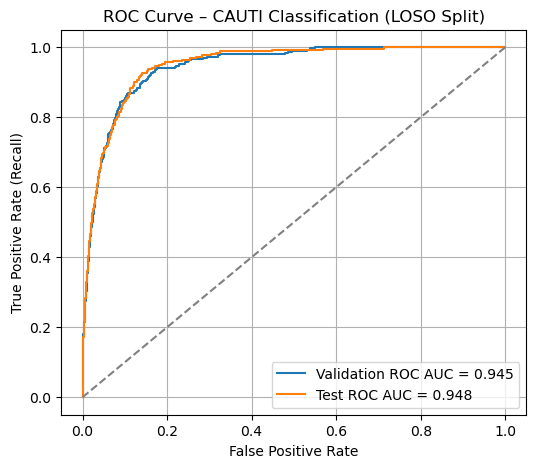

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curves for both validation and test sets
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
auc_val = roc_auc_score(y_val, y_val_prob)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr_val, tpr_val, label=f"Validation ROC AUC = {auc_val:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – CAUTI Classification (LOSO Split)")
plt.legend()
plt.grid(True)
plt.show()


# Precision Recall Curve

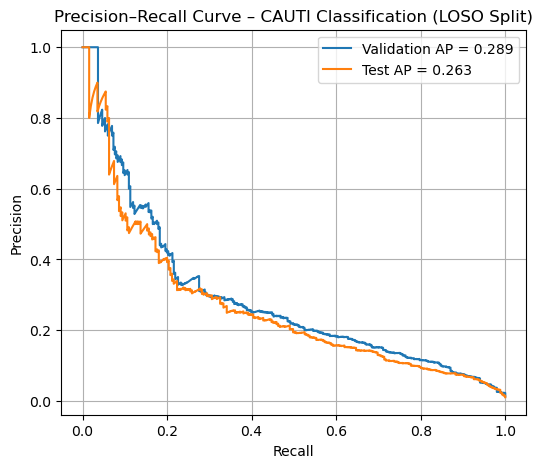

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall curves for both validation and test sets
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_prob)
ap_val = average_precision_score(y_val, y_val_prob)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_prob)
ap_test = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall_val, precision_val, label=f"Validation AP = {ap_val:.3f}")
plt.plot(recall_test, precision_test, label=f"Test AP = {ap_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – CAUTI Classification (LOSO Split)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
corr = X.corrwith(y).abs().sort_values(ascending=False)

high_corr = corr[corr >= 0.3]

print(high_corr)


Series([], dtype: float64)


<Figure size 500x400 with 0 Axes>

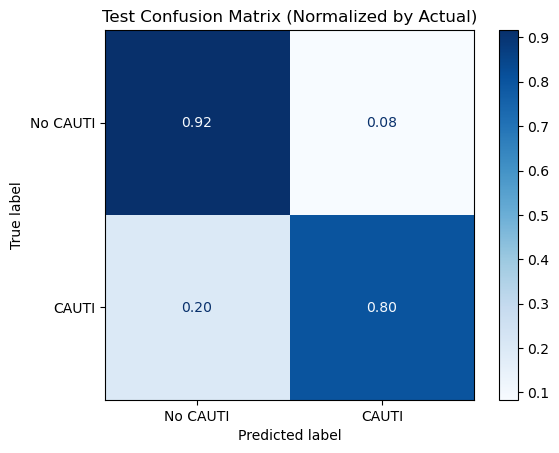

Test Confusion Matrix (Normalized by Actual):
[[0.91632705 0.08367295]
 [0.2        0.8       ]]


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -----------------------------
# Test – NORMALIZED (by actual class)
# -----------------------------
cm_test_norm = confusion_matrix(
    y_test,
    y_test_pred_best,
    normalize="true"   # normalize row-wise (actual labels)
)

disp_test_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_test_norm,
    display_labels=["No CAUTI", "CAUTI"]
)

plt.figure(figsize=(5, 4))
disp_test_norm.plot(
    cmap="Blues",
    values_format=".2f"
)
plt.title("Test Confusion Matrix (Normalized by Actual)")
plt.grid(False)
plt.show()

print("Test Confusion Matrix (Normalized by Actual):")
print(cm_test_norm)


<Figure size 500x400 with 0 Axes>

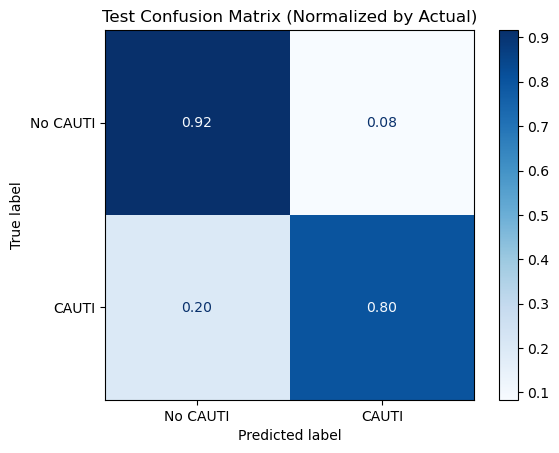

Test Confusion Matrix (Normalized by Actual):
[[0.91632705 0.08367295]
 [0.2        0.8       ]]


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -----------------------------
# Test – NORMALIZED (by actual class)
# -----------------------------
cm_test_norm = confusion_matrix(
    y_test,
    y_test_pred_best,
    normalize="true"
)

disp_test_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_test_norm,
    display_labels=["No CAUTI", "CAUTI"]
)

plt.figure(figsize=(5, 4))
disp_test_norm.plot(
    cmap="Blues",
    values_format=".2f"
)
plt.title("Test Confusion Matrix (Normalized by Actual)")
plt.grid(False)
plt.show()

print("Test Confusion Matrix (Normalized by Actual):")
print(cm_test_norm)
